# <center><font color="#000080">DÉTECTEZ DES FAUX BILLETS AVEC PYTHON</font>
<img src=https://user.oc-static.com/upload/2020/11/25/16063163322759_Screen%20Shot%202020-11-05%20at%2011.15.15.png>

## <span style="color : #00BFFF">**Import des librairies**</span> <a></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.formula.api import ols
from statsmodels.stats.diagnostic import het_white , normal_ad
from sklearn.linear_model import LinearRegression

from statsmodels.compat import lzip
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels

from sklearn import decomposition
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from matplotlib.collections import LineCollection
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn import decomposition, preprocessing
from sklearn import cluster, metrics
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

from statsmodels.api import Logit
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, f1_score, classification_report

from scipy.stats import t, shapiro
from statsmodels.stats.outliers_influence import variance_inflation_factor

## <span style="color : #00BFFF">**Les fonctions**</span> <a></a>

In [2]:
## Fonction qui permettra afficher le type de données et les valeurs nulles
def testerColonnes(df):
    tab_info=pd.DataFrame(df.dtypes).T.rename(index={0:'Type de colonne'})
    tab_info=tab_info.append(pd.DataFrame(df.isnull().sum()).T.rename(index={0:'Valeurs nulles'}))
    tab_info=tab_info.append(pd.DataFrame(round(df.isnull().sum()/df.shape[0]*100,2)).T.rename(index={0:'Valeurs nulles (%)'}))
    print(tab_info)

In [3]:
## Fonction qui représente graphiquement les Éboulis des valeurs propres
def display_scree_plot(pca):
    plt.figure(figsize=(9,8))
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree, color = '#1E90FF', edgecolor='darkblue')
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.axhline(y = 17, linewidth = .5, color = "dimgray", linestyle = "--") # ligne 17 = 100 / 6 (nb dimensions/variables)
    plt.xlabel("Rang de l'axe d'inertie", weight='bold',size=16)
    plt.ylabel("Pourcentage d'inertie", weight='bold',size=16)
    plt.title("Éboulis des valeurs propres", fontsize=22, weight='bold', color='Black', loc='center')
    plt.show(block=False)

In [4]:
## Fonction qui représente graphiquement le Cercle des corrélations
def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks:
        if d2 < n_comp:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(14,14))

            # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
                # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='11', ha='right', va='center', rotation=label_rotation, color="black", alpha=0.8)
            
            # affichage du cercle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)

In [5]:
## Procédure ascendante ou forward
def forward_selected(data, response):
    """Linear model designed by forward selection.

    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and response

    response: string, name of response column in data

    Returns:
    --------
    model: an "optimal" fitted statsmodels linear model
           with an intercept
           selected by forward selection
           evaluated by adjusted R-squared
    """
    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    current_score, best_new_score = 0.0, 0.0
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {} + 1".format(response,
                                           ' + '.join(selected + [candidate]))
            score = smf.ols(formula, data).fit().rsquared_adj
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
        if current_score < best_new_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
    formula = "{} ~ {} + 1".format(response,
                                   ' + '.join(selected))
    model = smf.ols(formula, data).fit()
    return model


def backward_selected(data, response):
    """Linear model designed by backward selection.

    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and response

    response: string, name of response column in data

    Returns:
    --------
    model: an "optimal" fitted statsmodels linear model
           with an intercept
           selected by backward selection
           evaluated by parameters p-value
    """
    remaining = set(data._get_numeric_data().columns)
    if response in remaining:
        remaining.remove(response)
    cond = True

    while remaining and cond:
        formula = "{} ~ {} + 1".format(response,' + '.join(remaining))
        print('_______________________________')
        print(formula)
        model = smf.ols(formula, data).fit()
        score = model.pvalues[1:]
        toRemove = score[score == score.max()]
        if toRemove.values > 0.05:
            print('remove', toRemove.index[0], '(p-value :', round(toRemove.values[0],3), ')')
            remaining.remove(toRemove.index[0])
        else:
            cond = False
            print('is the final model !')
        print('')
    print(model.summary())
    
    return model

## <span style="color : #00BFFF">**Import des données**</span> <a></a>

### billets.csv

In [6]:
billets_df = pd.read_csv('billets.csv', sep=";", decimal='.')
billets_df.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


### billets_production.csv

In [7]:
billets_production_df = pd.read_csv('billets_production.csv', sep=",", decimal='.')
billets_production_df.head()

,diagonal,height_left,height_right,margin_low,margin_up,length,id
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5


## <span style="color : #00BFFF">**Observation des données**</span> <a></a>

In [8]:
billets_df.describe()

,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500.000000,1500.000000,1500.000000,1463.000000,1500.000000,1500.00000
mean,171.958440,104.029533,103.920307,4.485967,3.151473,112.67850
std,0.305195,0.299462,0.325627,0.663813,0.231813,0.87273
min,171.040000,103.140000,102.820000,2.980000,2.270000,109.49000
25%,171.750000,103.820000,103.710000,4.015000,2.990000,112.03000
50%,171.960000,104.040000,103.920000,4.310000,3.140000,112.96000
75%,172.170000,104.230000,104.150000,4.870000,3.310000,113.34000
max,173.010000,104.880000,104.950000,6.900000,3.910000,114.44000


Nous avons un total de 6 dimensions en plus de la colonne qui distingue si un billet est vrai ou non ('is_genuine'). Cette colonne particulière ne se trouve pas dans les données de production.

In [9]:
testerColonnes(billets_df)

                   is_genuine diagonal height_left height_right margin_low  \
Type de colonne          bool  float64     float64      float64    float64   
Valeurs nulles              0        0           0            0         37   
Valeurs nulles (%)        0.0      0.0         0.0          0.0       2.47   

                   margin_up   length  
Type de colonne      float64  float64  
Valeurs nulles             0        0  
Valeurs nulles (%)       0.0      0.0  


Les types de données sont corrects, cependant nous constatons qu'il nous manque 37 données (2.47%) dans la colonne 'margin_low'.

In [10]:
billets_df.loc[billets_df['margin_low'].isnull(),:]

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
72,True,171.94,103.89,103.45,NaN,3.25,112.79
99,True,171.93,104.07,104.18,NaN,3.14,113.08
151,True,172.07,103.80,104.38,NaN,3.02,112.93
197,True,171.45,103.66,103.80,NaN,3.62,113.27
241,True,171.83,104.14,104.06,NaN,3.02,112.36
251,True,171.80,103.26,102.82,NaN,2.95,113.22
284,True,171.92,103.83,103.76,NaN,3.23,113.29
334,True,171.85,103.70,103.96,NaN,3.00,113.36
410,True,172.56,103.72,103.51,NaN,3.12,112.95
413,True,172.30,103.66,103.50,NaN,3.16,112.95


Comme on peut le voir, ce sont les 37 données qui manquent d'informations dans la colonne 'margin_low', pour remplir ces données manquantes il faut faire une régression linéaire.

In [11]:
# Nous supprimons la colonne 'is_genuine' pour pouvoir effectuer notre analyse correctement.
billets_6_df = billets_df.drop(columns='is_genuine')

# Separation des donnees manquantes
billets_train_df = billets_6_df.dropna()
billets_test_df = billets_6_df.loc[billets_6_df['margin_low'].isnull(),:]

In [12]:
# .corr() Nous l'utilisons pour trouver la corrélation par paire de toutes les colonnes de la trame de données.
billets_train_df.corr()

,diagonal,height_left,height_right,margin_low,margin_up,length
diagonal,1.000000,0.018265,-0.019428,-0.111534,-0.059147,0.100758
height_left,0.018265,1.000000,0.235132,0.302643,0.243812,-0.314344
height_right,-0.019428,0.235132,1.000000,0.391085,0.306867,-0.404272
margin_low,-0.111534,0.302643,0.391085,1.000000,0.431606,-0.666753
margin_up,-0.059147,0.243812,0.306867,0.431606,1.000000,-0.521139
length,0.100758,-0.314344,-0.404272,-0.666753,-0.521139,1.000000


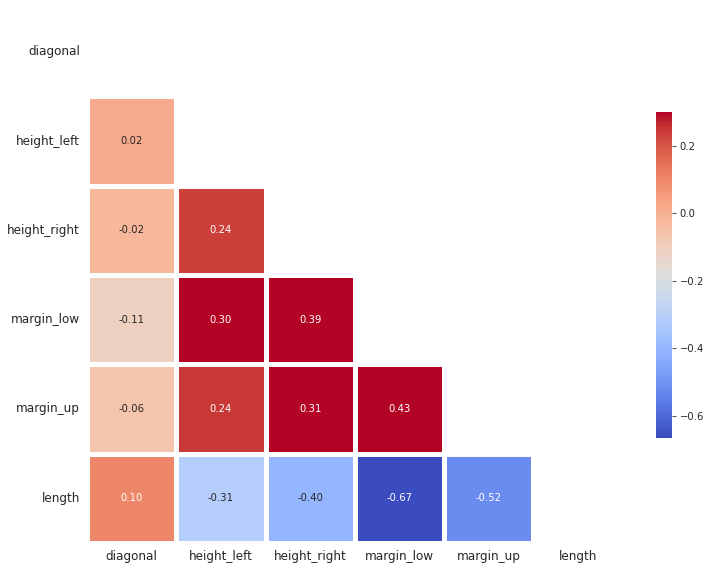

In [13]:
corr = billets_train_df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(12, 12))
    ax = sns.heatmap(corr, mask=mask, vmax=.3, square=True, 
                     linewidth=5, annot = True, fmt='.2f', cmap="coolwarm", cbar_kws={"shrink": 0.5})
    plt.xticks(rotation=0, fontsize=12)
    plt.yticks(rotation=0, fontsize=12)

On voit qu'il y a une forte corrélation négative entre 'margin_low' et 'length' avec une valeur de -0.67

# <font color="#8333ff">RÉGRESSION LINÉAIRE MULTIPLE SUR LE JEU DE DONNÉES</font>

In [14]:
reg_multi = smf.ols('margin_low ~ diagonal + height_left + height_right + margin_up + length', data = billets_train_df).fit()
print(reg_multi.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.477
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                     266.1
Date:                Fri, 05 Aug 2022   Prob (F-statistic):          2.60e-202
Time:                        14:05:30   Log-Likelihood:                -1001.3
No. Observations:                1463   AIC:                             2015.
Df Residuals:                    1457   BIC:                             2046.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       22.9948      9.656      2.382   

- P_value: Ici, elle est très faible et inférieure au seuil alpha 5 %, on rejet l'hypothèse nulle, selon laquelle le paramètre est égal à 0 : les paramètres sont donc significativement différents de 0.
- Le $R^{2}$ vaut environ 0.477, et le $R^{2}$ ajusté est d'environ 0.476, n'est pas satisfaisant (inférieur à 0,5).

In [15]:
# Nous effectuons différentes régressions multiples en supprimant une variable à la fois pour tester notre modèle
reg_multi_1 = smf.ols('margin_low ~ height_left + height_right + margin_up + length', data= billets_train_df).fit(cov_type='HC1')
reg_multi_2 = smf.ols('margin_low ~ height_right + margin_up + length', data= billets_train_df).fit(cov_type='HC1')
reg_multi_3 = smf.ols('margin_low ~ margin_up + length', data= billets_train_df).fit(cov_type='HC1')
reg_multi_4 = smf.ols('margin_low ~ length', data= billets_train_df).fit(cov_type='HC1')

In [16]:
# Le modèle avec l'AIC le plus bas offre le meilleur ajustement.
print("Modèle complet :", "AIC:", "{:.2f}".format(reg_multi.aic), "  R2 adj :", "{:.2f}".format(reg_multi.rsquared_adj))
print("Modèle -1 :", "AIC:", "{:.2f}".format(reg_multi_1.aic), "  R2 adj :", "{:.2f}".format(reg_multi_1.rsquared_adj))
print("Modèle -2 :", "AIC:", "{:.2f}".format(reg_multi_2.aic), "  R2 adj :", "{:.2f}".format(reg_multi_2.rsquared_adj))
print("Modèle -3 :", "AIC:", "{:.2f}".format(reg_multi_3.aic), "  R2 adj :", "{:.2f}".format(reg_multi_3.rsquared_adj))
print("Modèle -4 :", "AIC:", "{:.2f}".format(reg_multi_4.aic), "  R2 adj :", "{:.2f}".format(reg_multi_4.rsquared_adj))

Modèle complet : AIC: 2014.65   R2 adj : 0.48
Modèle -1 : AIC: 2019.84   R2 adj : 0.47
Modèle -2 : AIC: 2033.59   R2 adj : 0.47
Modèle -3 : AIC: 2071.81   R2 adj : 0.45
Modèle -4 : AIC: 2095.64   R2 adj : 0.44


## <font color="#800080">Procédure descendante ou backward</font>

In [17]:
# On initialise la procédure en intégrant tous les régresseurs, puis on élimine à chaque pas le régresseur associé à la plus petite diminution de la somme des carrés expliqués (la constante est toujours conservée).
columns = ['margin_low','diagonal','height_left','height_right','margin_up','length']
reg_backward = backward_selected(billets_train_df[columns], 'margin_low')

_______________________________
margin_low ~ diagonal + margin_up + height_left + length + height_right + 1
is the final model !

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.477
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                     266.1
Date:                Fri, 05 Aug 2022   Prob (F-statistic):          2.60e-202
Time:                        14:05:30   Log-Likelihood:                -1001.3
No. Observations:                1463   AIC:                             2015.
Df Residuals:                    1457   BIC:                             2046.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]

Finalement nous obtenons le même résultat, qui est d'intégrer toutes les variables.

In [18]:
# Nous ajoutons une nouvelle colonne 'margin_low_pred' avec les valeurs prédites de la régression multiple
billets_train_df = billets_train_df.copy()
billets_train_df["margin_low_pred"] = round(reg_multi.predict({'diagonal': billets_train_df['diagonal'], 
                                               'height_left': billets_train_df['height_left'], 
                                               'height_right': billets_train_df['height_right'], 
                                               'margin_up': billets_train_df['margin_up'], 
                                               'length': billets_train_df['length']}),2)
billets_train_df.head()

,diagonal,height_left,height_right,margin_low,margin_up,length,margin_low_pred
0,171.81,104.86,104.95,4.52,2.89,112.83,4.79
1,171.46,103.36,103.66,3.77,2.99,113.09,4.14
2,172.69,104.48,103.50,4.40,2.94,113.16,4.13
3,171.36,103.91,103.94,3.62,3.01,113.51,4.16
4,171.73,104.28,103.46,4.04,3.48,112.54,4.58


## <font color="#800080">Test d'hypothèses par analyse des résidus</font>

## Normalité de la distribution des résidus</font>

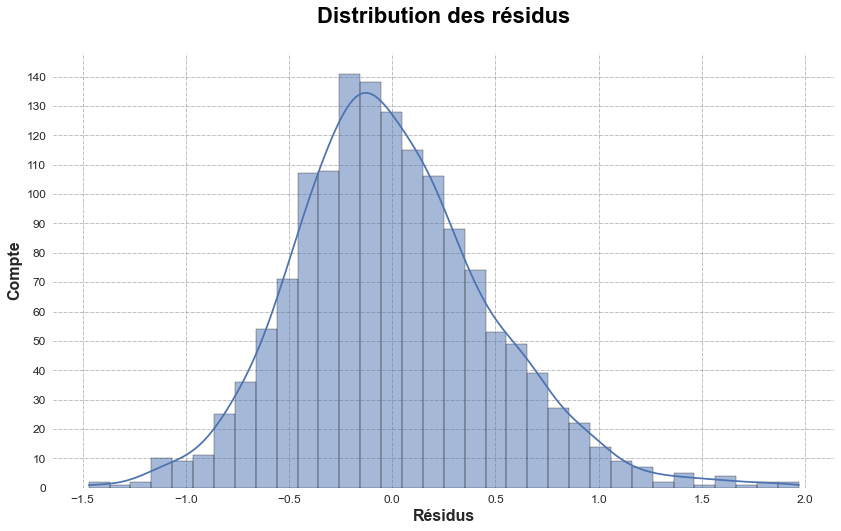

In [19]:
# Creation d'une colonne contenant les residus:
billets_train_df["residual"] = billets_train_df["margin_low"] - billets_train_df["margin_low_pred"]

# Graphique:
plt.style.use('seaborn')
fig, ax = plt.subplots(figsize = (14,8))
ax.set_title("Distribution des résidus",
 fontsize=22, weight='bold', color='Black', loc='center',pad=30)
plt.box(False)
ax.yaxis.grid(linewidth=0.5,color='grey',linestyle='-.')
ax.xaxis.grid(linewidth=0.5,color='grey',linestyle='-.')

sns.histplot(billets_train_df["residual"], kde=True)
plt.ylabel("Compte", weight='bold', size=16)
plt.xlabel("Résidus", weight='bold', size=16)
plt.yticks(np.arange(0, 150, 10))
plt.xticks(rotation=0, fontsize=12)
plt.yticks(rotation=0, fontsize=12)
plt.show()

In [20]:
# Normalite: Test d'Aderson-Darling
print("La p-value du test d'Aderson-Darling :", normal_ad(billets_train_df["residual"])[1])

La p-value du test d'Aderson-Darling : 4.343779877248881e-12


In [21]:
# Norlamite Test de Shapiro-Wilk
print("La p-value du test de Shapiro-Wilk :", shapiro(reg_multi.resid))

La p-value du test de Shapiro-Wilk : ShapiroResult(statistic=0.9857879281044006, pvalue=8.536943374437556e-11)


Une p-value inférieure au seuil alpha $5$%, pour le test d'Anderson-Darling et Shapiro-Wilk indique que l'hypothèse nulle $H0$ de normalité de la distribution des résidus est rejetée, les résidus suivent une distribution Normale.

## Testez l’homoscédasticité

In [22]:
# Tester l'homoscédasticité
# On va tester la constance de la variance des résidus : Test Breusch Pagan
nombres = ['Test Statistic', 'p-value', 'F-Statistic', 'F-Test p-value']
test = statsmodels.stats.diagnostic.het_breuschpagan(reg_multi.resid, reg_multi.model.exog)
lzip(nombres, test)

[('Test Statistic', 80.16261280175056),
 ('p-value', 7.759535216194938e-16),
 ('F-Statistic', 16.89235884615347),
 ('F-Test p-value', 2.9227496566219426e-16)]

La p-valeur ici est inférieure à $5$%, on rejette l'hypothèse $H0$ selon laquelle les variances sont constantes (l'hypothèse d’homoscédasticité).

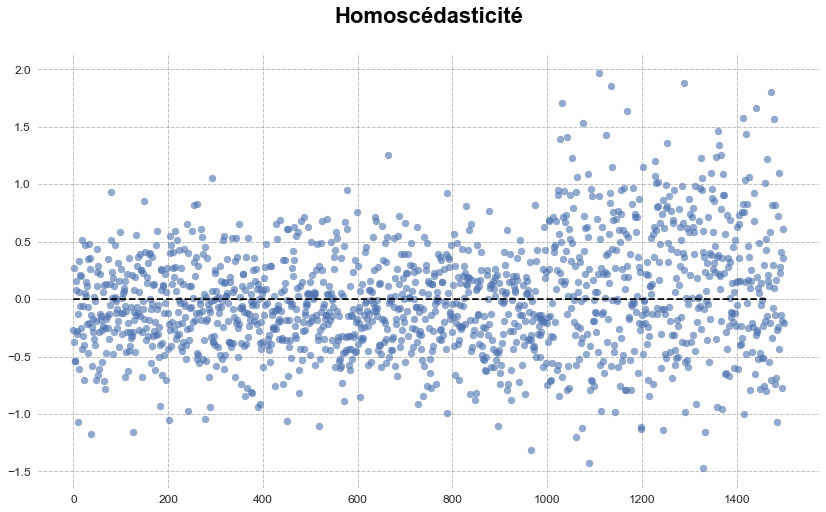

In [23]:
# Graphique:
plt.style.use('seaborn')
fig, ax = plt.subplots(figsize = (14,8))
ax.set_title("Homoscédasticité",
 fontsize=22, weight='bold', color='Black', loc='center',pad=30)
plt.box(False)
ax.yaxis.grid(linewidth=0.5,color='grey',linestyle='-.')
ax.xaxis.grid(linewidth=0.5,color='grey',linestyle='-.')
plt.scatter(x = billets_train_df.index, y = billets_train_df["residual"], alpha=0.6)
plt.plot(np.repeat(0, len(billets_train_df.index)+2), color="black", linestyle='--')
plt.xticks(rotation=0, fontsize=12)
plt.yticks(rotation=0, fontsize=12)
plt.show()

La répartition semble aléatoire sur le graphique. Cette forme de cône que peut prendre la répartition des résidus en fonction d'une variable explicative.

## Colinéarité des variables

Une autre chose à vérifier est l'éventuelle colinéarité approchée des variables :

In [24]:
variables = reg_multi.model.exog
[variance_inflation_factor(variables, i) for i in np.arange(1,variables.shape[1])]

[1.0136128990686315,
 1.1382605736082538,
 1.2301145155560338,
 1.404403778184362,
 1.5769501453665806]

Ici, tous les coefficients sont inférieurs à 10, il n'y a donc pas de problème de colinéarité.

## <font color="#800080">Identification des individus atypiques et influents</font>

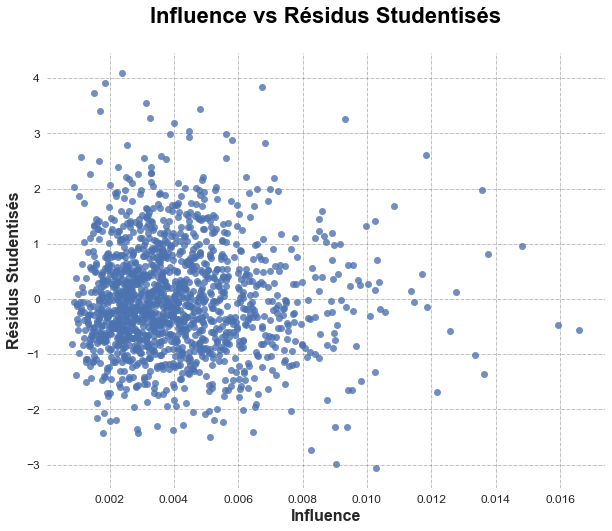

,margin_low,dfb_Intercept,dfb_diagonal,dfb_height_left,dfb_height_right,dfb_margin_up,dfb_length,cooks_d,standard_resid,leverage,dffits_internal,student_resid,dffits
0,4.52,0.038028,0.011150,-0.040676,-0.050650,0.028339,-0.018016,0.000894,-0.563593,0.016606,-0.073239,-0.563461,-0.073221
1,3.77,-0.047734,0.031782,0.040802,0.006819,0.006051,0.006096,0.000597,-0.769710,0.006015,-0.059874,-0.769603,-0.059866
2,4.40,-0.028752,0.034142,0.027975,-0.020340,-0.010975,-0.001295,0.000457,0.572488,0.008298,0.052367,0.572356,0.052355
3,3.62,-0.031981,0.060924,0.001406,-0.016400,0.006425,-0.029579,0.000936,-1.118681,0.004467,-0.074934,-1.118778,-0.074940
4,4.04,-0.025618,0.021411,-0.027128,0.056039,-0.049448,-0.009670,0.001171,-1.121058,0.005558,-0.083813,-1.121157,-0.083821


In [25]:
student_resid = reg_multi.get_influence().resid_studentized_external
(cooks, p_val_cooks) = reg_multi.get_influence().cooks_distance
(dffits, p_val_dffits) = reg_multi.get_influence().dffits
leverage = reg_multi.get_influence().hat_matrix_diag

# Graphique:
plt.style.use('seaborn')
fig, ax = plt.subplots(figsize = (10,8))
ax.set_title("Influence vs Résidus Studentisés",
 fontsize=22, weight='bold', color='Black', loc='center',pad=30)
plt.box(False)
ax.yaxis.grid(linewidth=0.5,color='grey',linestyle='-.')
ax.xaxis.grid(linewidth=0.5,color='grey',linestyle='-.')
sns.regplot(x = leverage, y = reg_multi.resid_pearson, fit_reg=False)
plt.ylabel("Résidus Studentisés", weight='bold', size=16)
plt.xlabel("Influence", weight='bold', size=16)
plt.xticks(rotation=0, fontsize=12)
plt.yticks(rotation=0, fontsize=12)
plt.show()

# Creation d'un dataframe de travail:
iai_df = pd.concat([billets_train_df["margin_low"], reg_multi.get_influence().summary_frame()], axis = 1)
iai_df = iai_df.rename(columns={"hat_diag": "leverage"})
iai_df.head()

In [26]:
# Nous allons ici réaliser les tests à un niveau alpha=5% :
alpha = 0.05

# Récupérons n, le nombre d'individus de l'échantillon, et p, le nombre de variables.
n = billets_train_df.shape[0]
p = 6

Nous allons mener des analyses sur les valeurs atypiques et/ou influentes en travaillant sur un dataframe appelé  analyses.

In [27]:
analyses = pd.DataFrame({'obs':np.arange(1, n+1)})

## <font color="#2E8B57">Calculez les leviers</font>
On peut calculer les leviers comme ceci, en sachant que le seuil des leviers est de $2∗\frac{p}{n}$.

In [28]:
analyses['levier'] = reg_multi.get_influence().hat_matrix_diag
seuil_levier = 2*p/n

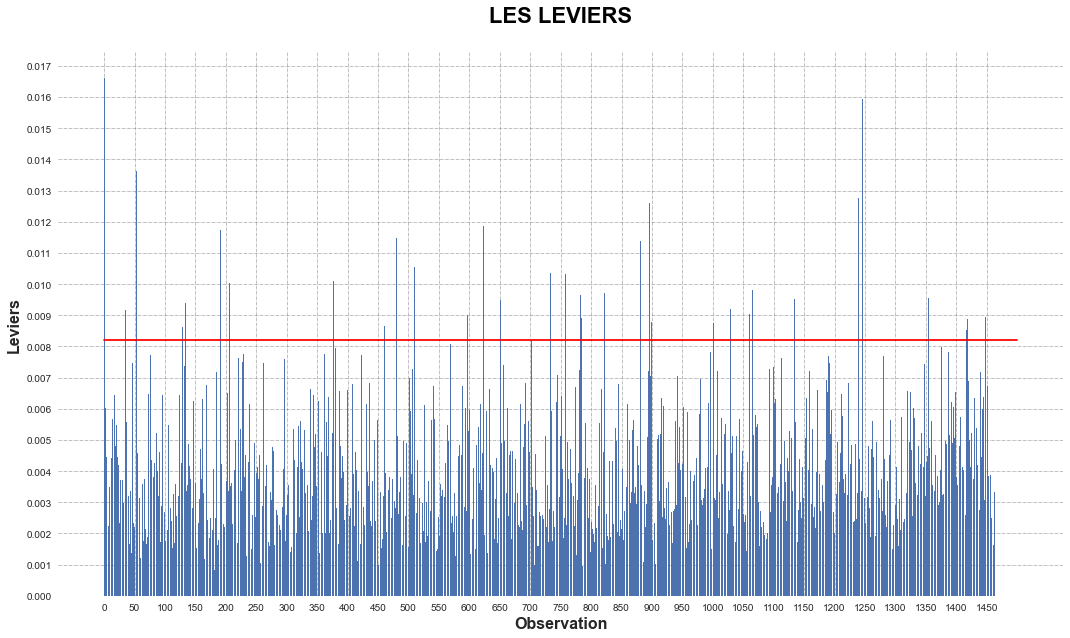

In [29]:
plt.style.use('seaborn')
fig, ax = plt.subplots(figsize = (18,10))
ax.set_title("LES LEVIERS",
 fontsize=22, weight='bold', color='Black', loc='center',pad=30)
plt.box(False)
ax.yaxis.grid(linewidth=0.5,color='grey',linestyle='-.')
ax.xaxis.grid(linewidth=0.5,color='grey',linestyle='-.')
plt.bar(analyses['obs'], analyses['levier'])
plt.xticks(np.arange(0, 1500, step=50))
plt.ylabel("Leviers", weight='bold', size=16)
plt.xlabel("Observation", weight='bold', size=16)
plt.yticks(np.arange(0, 0.2, 0.001))
plt.plot([0, 1500], [seuil_levier, seuil_levier], color='r')
plt.show()

Pour sélectionner les points pour lesquels le levier est supérieur au seuil, on exécute la ligne suivante :

In [30]:
analyses.loc[analyses['levier'] > seuil_levier, :]

,obs,levier
0,1,0.016606
2,3,0.008298
34,35,0.009156
52,53,0.013635
56,57,0.009087
...,...,...
1416,1417,0.008521
1417,1418,0.008870
1428,1429,0.008390
1441,1442,0.009325


## <font color="#2E8B57">Calculez les résidus studentisés</font>
Si l'on souhaite maintenant calculer les résidus studentisés, nous écrivons ceci, sachant que le seuil pour les résidus studentisés est une loi de Student à n-p-1 degrés de liberté :

In [31]:
analyses['rstudent'] = reg_multi.get_influence().resid_studentized_internal
seuil_rstudent = t.ppf(1-alpha/2, n-p-1)

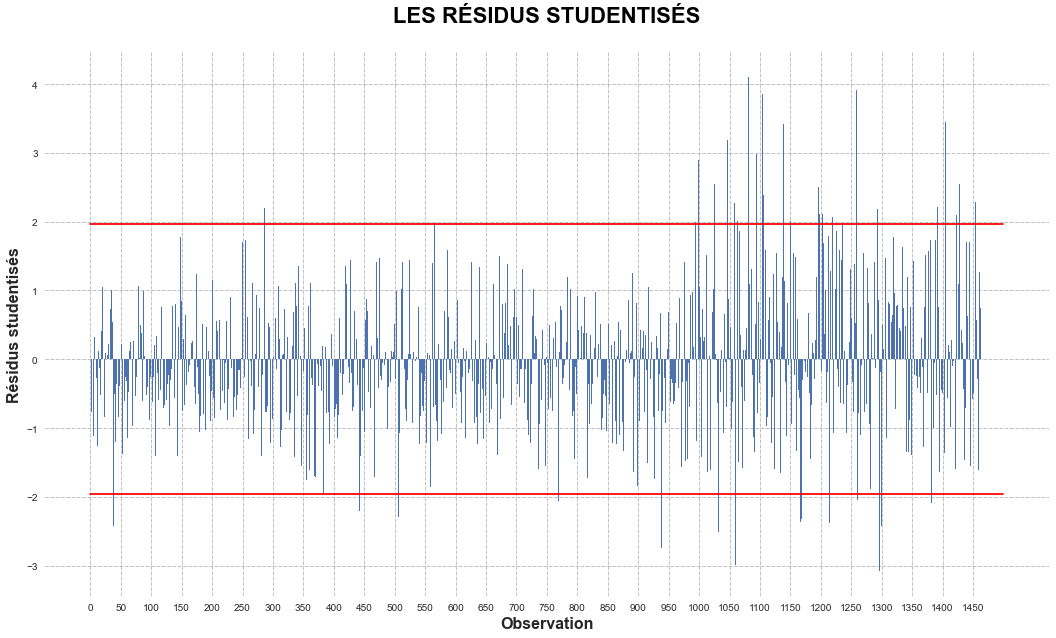

In [32]:
plt.style.use('seaborn')
fig, ax = plt.subplots(figsize = (18,10))
ax.set_title("LES RÉSIDUS STUDENTISÉS",
 fontsize=22, weight='bold', color='Black', loc='center', pad=30)
plt.box(False)
ax.yaxis.grid(linewidth=0.5,color='grey',linestyle='-.')
ax.xaxis.grid(linewidth=0.5,color='grey',linestyle='-.')
plt.bar(analyses['obs'], analyses['rstudent'])
plt.xticks(np.arange(0, 1500, step=50))
plt.ylabel("Résidus studentisés", weight='bold', size=16)
plt.xlabel("Observation", weight='bold', size=16)
plt.yticks(np.arange(-5, 5, 1))
plt.plot([0, 1500], [seuil_rstudent, seuil_rstudent], color='r')
plt.plot([0, 1500], [-seuil_rstudent, -seuil_rstudent], color='r')
plt.show()

## <font color="#2E8B57">Déterminez la distance de Cook</font>
Pour trouver la distance de Cook, nous exécutons ceci :

In [33]:
influence = reg_multi.get_influence().summary_frame()
influence.head()

,dfb_Intercept,dfb_diagonal,dfb_height_left,dfb_height_right,dfb_margin_up,dfb_length,cooks_d,standard_resid,hat_diag,dffits_internal,student_resid,dffits
0,0.038028,0.011150,-0.040676,-0.050650,0.028339,-0.018016,0.000894,-0.563593,0.016606,-0.073239,-0.563461,-0.073221
1,-0.047734,0.031782,0.040802,0.006819,0.006051,0.006096,0.000597,-0.769710,0.006015,-0.059874,-0.769603,-0.059866
2,-0.028752,0.034142,0.027975,-0.020340,-0.010975,-0.001295,0.000457,0.572488,0.008298,0.052367,0.572356,0.052355
3,-0.031981,0.060924,0.001406,-0.016400,0.006425,-0.029579,0.000936,-1.118681,0.004467,-0.074934,-1.118778,-0.074940
4,-0.025618,0.021411,-0.027128,0.056039,-0.049448,-0.009670,0.001171,-1.121058,0.005558,-0.083813,-1.121157,-0.083821


Le seuil de la distance de Cook est de n - p.

In [34]:
analyses['dcooks'] = influence['cooks_d']
seuil_dcook = 4/(n-p)

On peut détecter les observations influentes comme ceci :

In [35]:
analyses.loc[analyses['dcooks'] > seuil_dcook, :]

,obs,levier,rstudent,dcooks
52,53,0.013635,-1.372229,0.004338
80,81,0.003806,0.022997,0.003151
125,126,0.001589,0.172284,0.006308
243,244,0.002601,0.239331,0.004207
292,293,0.002852,0.522537,0.005768
...,...,...,...,...
1420,1421,0.006084,-1.590104,0.005875
1426,1427,0.005088,-1.669093,0.005099
1441,1442,0.009325,3.280337,0.009596
1450,1451,0.006730,-0.493361,0.003099


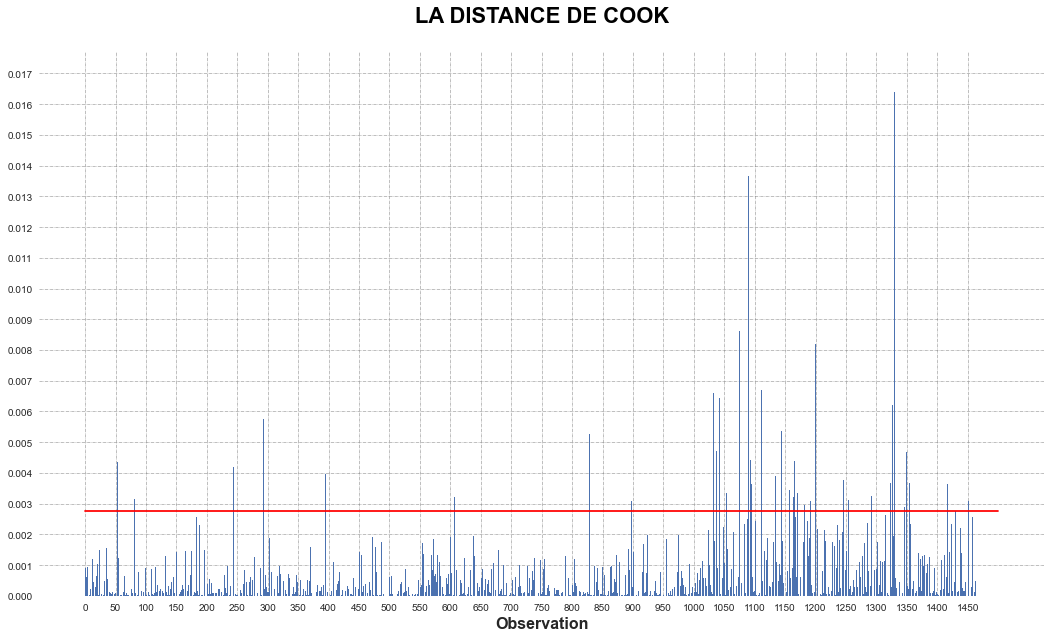

In [36]:
plt.style.use('seaborn')
fig, ax = plt.subplots(figsize = (18,10))
ax.set_title("LA DISTANCE DE COOK",
 fontsize=22, weight='bold', color='Black', loc='center',pad=30)
plt.box(False)
ax.yaxis.grid(linewidth=0.5,color='grey',linestyle='-.')
ax.xaxis.grid(linewidth=0.5,color='grey',linestyle='-.')
plt.bar(analyses['obs'], analyses['dcooks'])
plt.xticks(np.arange(0, 1500, step=50))
#plt.ylabel("Leviers", weight='bold', size=16)
plt.xlabel("Observation", weight='bold', size=16)
plt.yticks(np.arange(0, 0.02, 0.001))
plt.plot([0, 1500], [seuil_dcook, seuil_dcook], color='r')
plt.show()

On ne retire des points qu'après avoir vérifié qu'ils sont effectivement atypiques, voire aberrants, au vu du modèle estimé.

In [37]:
# Individus atypiques:
std_res = iai_df.student_resid
outlier = pd.DataFrame((iai_df["margin_low"][abs(std_res) > seuil_rstudent]))
print ("Résidus studentisés:\n", std_res.describe())
print("Nombre d'individus atypiques:", outlier.count())
print("\n")
# Identification des individus a forte influence:
hg_leverage = iai_df["margin_low"][abs(iai_df["leverage"]) > seuil_levier]
print(iai_df["leverage"].describe())
print("Nombre d'individus à forte influence:", hg_leverage.count())

Résidus studentisés:
 count    1463.000000
mean        0.000133
std         1.001419
min        -3.087577
25%        -0.660578
50%        -0.086814
75%         0.570403
max         4.127099
Name: student_resid, dtype: float64
Nombre d'individus atypiques: margin_low    79
dtype: int64


count    1463.000000
mean        0.004101
std         0.002134
min         0.000840
25%         0.002561
50%         0.003645
75%         0.005140
max         0.016606
Name: leverage, dtype: float64
Nombre d'individus à forte influence: 75


In [38]:
# Identification des individus atypiques avec une forte influence:
outliers_hg_lev =pd.merge(outlier, hg_leverage, left_index=True, right_index=True)
print(outliers_hg_lev.count())
print("\n")
print(outliers_hg_lev)

margin_low_x    8
margin_low_y    8
dtype: int64


      margin_low_x  margin_low_y
664           5.04          5.04
965           3.45          3.45
1022          6.03          6.03
1074          4.36          4.36
1089          3.86          3.86
1199          4.49          4.49
1329          3.82          3.82
1478          6.08          6.08


Il y a 8 individus à la fois influents et atypiques. On supprime les individus influents et on relance la régression linéaire.

In [39]:
# Suppression des iai:
billets_train_df = billets_6_df.dropna()
billet_sans_iai_df = billets_train_df.drop(outliers_hg_lev.index)

reg_multi_sans_iai = smf.ols('margin_low ~ diagonal + height_left + height_right + margin_up + length', data = billet_sans_iai_df).fit()
print(reg_multi_sans_iai.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.493
Model:                            OLS   Adj. R-squared:                  0.491
Method:                 Least Squares   F-statistic:                     281.5
Date:                Fri, 05 Aug 2022   Prob (F-statistic):          1.45e-210
Time:                        14:05:42   Log-Likelihood:                -969.98
No. Observations:                1455   AIC:                             1952.
Df Residuals:                    1449   BIC:                             1984.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       24.9633      9.511      2.625   

- Le R² (ajusté ou non) augmente légèrement (0.47 à 0.49).

- L'AIC passe de 2015 à 1952.
- Le BIC de 2046 à 1984.
- Les coefficients et leurs statistiques n'ont pas beaucoup changé.

Le nombre d'individus influents et atypiques est faible (8/1463), ils n'influencent finalement pas tant le jeu de données et leur suppression n'apporte pas beaucoup au modèle, la décision est prise de continuer avec eux tout en gardant leur présence à l'esprit.

In [40]:
billets_test_df = billets_test_df.copy()
billets_test_df.loc[:,"margin_low"] = round(reg_multi.predict({'diagonal': billets_test_df['diagonal'], 
                                               'height_left': billets_test_df['height_left'], 
                                               'height_right': billets_test_df['height_right'], 
                                               'margin_up': billets_test_df['margin_up'], 
                                               'length': billets_test_df['length']}),2)
billets_test_df.head()

,diagonal,height_left,height_right,margin_low,margin_up,length
72,171.94,103.89,103.45,4.32,3.25,112.79
99,171.93,104.07,104.18,4.39,3.14,113.08
151,172.07,103.80,104.38,4.41,3.02,112.93
197,171.45,103.66,103.80,4.32,3.62,113.27
241,171.83,104.14,104.06,4.65,3.02,112.36


# <font color="#8333ff">APPLICATION DU MODÈLE</font>

In [41]:
#Données sans valeurs nulles
billets_1_df = billets_df.dropna()
#Données avec des valeurs nulles
billets_2_df = billets_df.loc[billets_df['margin_low'].isnull(),:].copy()
#Application du modèle
billets_2_df.loc[:,"margin_low"] = round(reg_multi.predict({'diagonal': billets_2_df['diagonal'], 
                                               'height_left': billets_2_df['height_left'], 
                                               'height_right': billets_2_df['height_right'], 
                                               'margin_up': billets_2_df['margin_up'], 
                                               'length': billets_2_df['length']}),2)
# Concatenation:
reg_multi_result = [billets_1_df, billets_2_df]
billet_final_df = pd.concat(reg_multi_result)
billet_final_df.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


In [42]:
billet_final_df.describe()

,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.00000
mean,171.958440,104.029533,103.920307,4.483480,3.151473,112.67850
std,0.305195,0.299462,0.325627,0.659643,0.231813,0.87273
min,171.040000,103.140000,102.820000,2.980000,2.270000,109.49000
25%,171.750000,103.820000,103.710000,4.020000,2.990000,112.03000
50%,171.960000,104.040000,103.920000,4.310000,3.140000,112.96000
75%,172.170000,104.230000,104.150000,4.870000,3.310000,113.34000
max,173.010000,104.880000,104.950000,6.900000,3.910000,114.44000


Il n'y a plus de valeurs manquantes, nous allons maintenant procéder aux analyses suivantes.

## <font color="#800080">Analyse descriptive</font>

            diagonal  height_left  height_right  margin_low  margin_up  length
is_genuine                                                                    
False            500          500           500         500        500     500
True            1000         1000          1000        1000       1000    1000


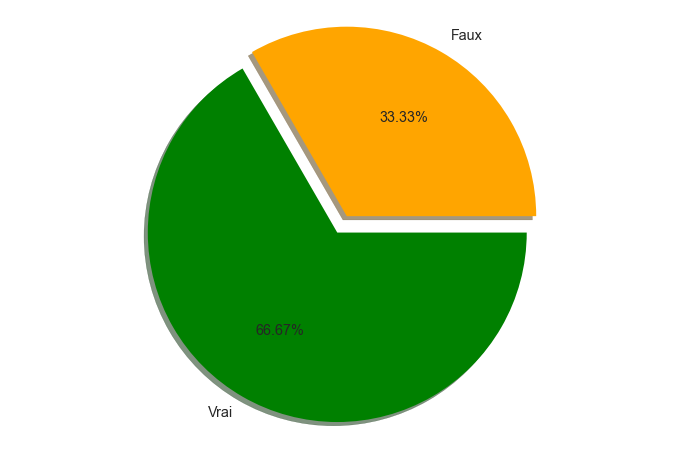

In [43]:
# Repartition des vrais/faux billets
print(billet_final_df.groupby(["is_genuine"]).count())

# Graphique:
fig1, ax1 = plt.subplots(figsize = (12,8))
ax.set_title("Répartition des billets",
 fontsize=22, weight='bold', color='Black', loc='center',pad=30)
plt.box(False)
ax1.pie(billet_final_df.groupby(["is_genuine"])["diagonal"].count(),
        labels=["Faux","Vrai"],
        explode= (0, 0.1), 
        autopct="%1.2f%%",
        textprops={'size': 'x-large'},
        colors=["#FFA500","#008000"],
        shadow=True)
ax1.axis("equal")
plt.show()

In [44]:
# Billets moyens selon l'authenticitee:
print(billet_final_df.groupby(["is_genuine"]).mean())

             diagonal  height_left  height_right  margin_low  margin_up  \
is_genuine                                                                
False       171.90116    104.19034     104.14362     5.21410    3.35016   
True        171.98708    103.94913     103.80865     4.11817    3.05213   

               length  
is_genuine             
False       111.63064  
True        113.20243  


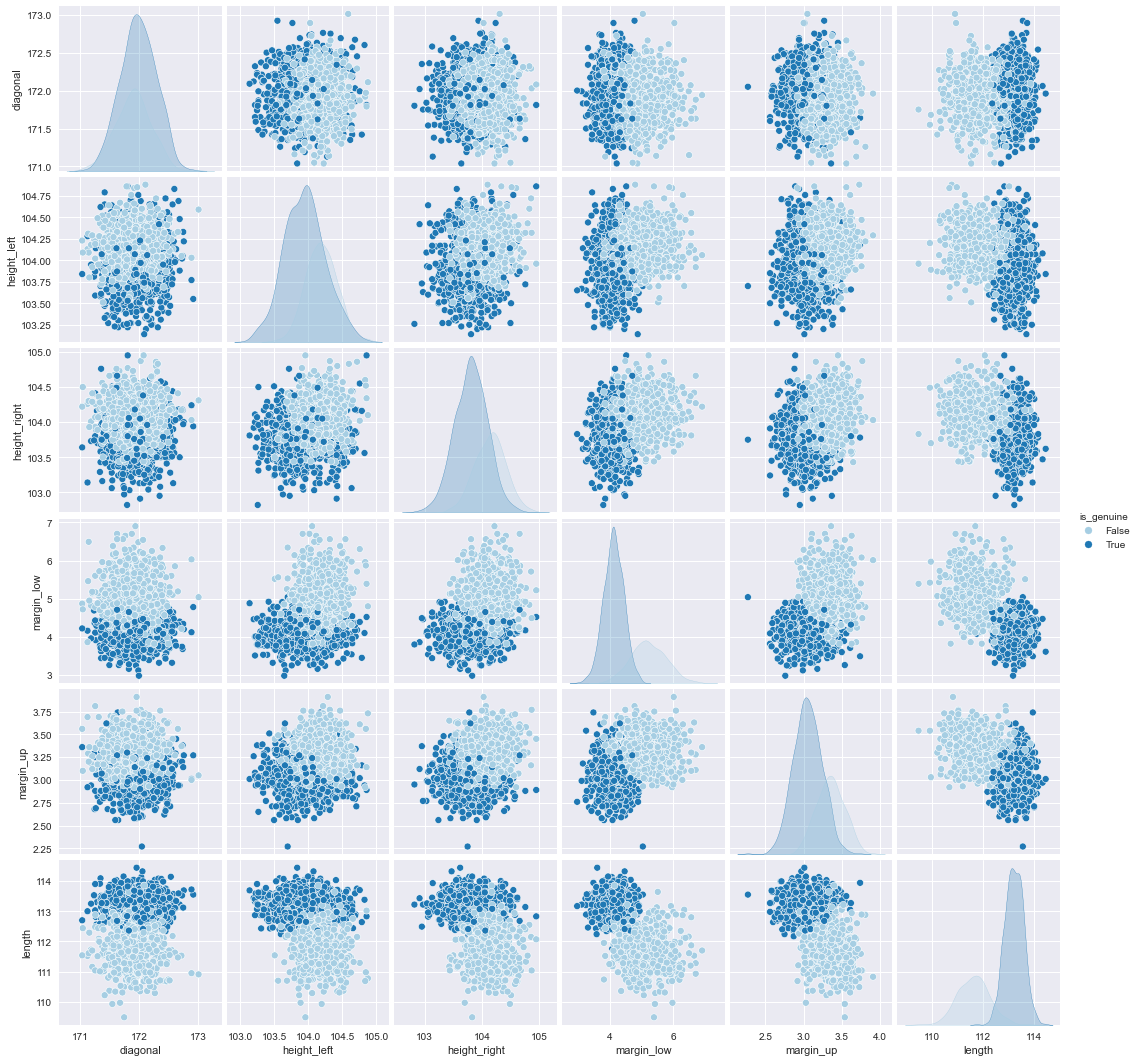

In [45]:
# Pair plot:
sns.pairplot(billet_final_df, hue="is_genuine", palette="Paired")
plt.show()

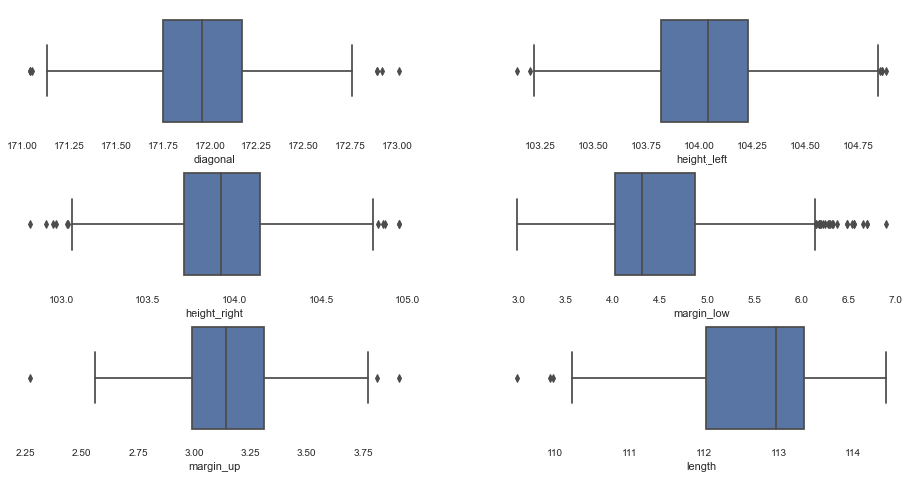

In [46]:
# Representation graphique des outliers:
plt.style.use('seaborn')
fig, ax = plt.subplots(figsize = (16, 8))
a = 3; b = 2; c = 1
for i in billet_final_df.loc[:, billet_final_df.columns != "is_genuine"]:
    plt.subplot(a, b, c)
    plt.xlabel(i)
    sns.boxplot(x = billet_final_df[i])
    c = c + 1
    plt.box(False)
plt.show()

On voit qu'il y des outiler dans toutes les dimensions.

## <font color="#2E8B57">K-MEANS</font>

In [47]:
# Nombre de clusters:
n_clust = 2

# Centrage et Réduction
kmeans2 = KMeans(n_clusters = n_clust)
x_Kmeans2 = kmeans2.fit_transform(billet_final_df[["diagonal","height_left","height_right","margin_low","margin_up","length"]])

In [48]:
# Ajout d'une colonne contenant le cluster attribue:
clusters_km = kmeans2.labels_

centroids_km = kmeans2.cluster_centers_

In [49]:
# Nombre d'individus par groupes
pd.Series(clusters_km).value_counts()

0    1016
1     484
dtype: int64

In [50]:
#x_Kmeans2.cluster_centers_
kmeans2.cluster_centers_

array([[171.98699803, 103.95165354, 103.81333661,   4.1241437 ,
          3.0582185 , 113.19615157],
       [171.89849174, 104.19301653, 104.14485537,   5.23778926,
          3.3472314 , 111.5918595 ]])

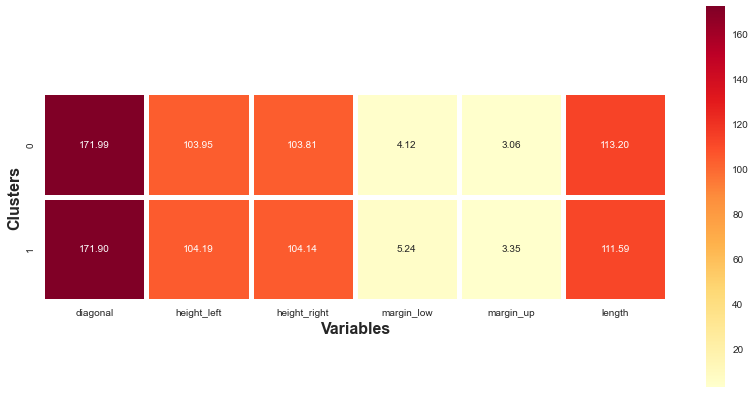

In [51]:
billets_centroid_df = pd.DataFrame(centroids_km, columns=billet_final_df[["diagonal","height_left","height_right","margin_low","margin_up","length"]].columns)
fig2 = billets_centroid_df
fig, ax = plt.subplots(figsize=(14, 14))
sns.heatmap(fig2, linewidth=5, annot = True, fmt='.2f', cmap="YlOrRd", cbar_kws={"shrink": 0.5}, square=True)
plt.ylabel("Clusters",weight='bold',size=16)
plt.xlabel("Variables",weight='bold',size=16)
#fig.savefig("output.png")
plt.show()

## <font color="#2E8B57">ACP</font>

In [52]:
# Préparation des données pour le Clustering
data = (billet_final_df[["diagonal","height_left","height_right","margin_low","margin_up","length"]]).values
index = billet_final_df.index
features = (billet_final_df[["diagonal","height_left","height_right","margin_low","margin_up","length"]]).columns

# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(data)
X_scaled = std_scale.transform(data)

In [53]:
# choix du nombre de composantes à calculer
n_comp = 6

# Calcul des composantes principales
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)

PCA(n_components=6)

In [54]:
eig = pd.DataFrame(
    {
        "Dimension" : ["Dim" + str(x + 1) for x in range(6)], 
        "Variance expliquée" : pca.explained_variance_,
        "Variance expliquée (%)" : np.round(pca.explained_variance_ratio_ * 100,1),
        "Cum. var. expliquée (%)" : np.round(np.cumsum(pca.explained_variance_ratio_) * 100,1)
    }
)
eig

,Dimension,Variance expliquée,Variance expliquée (%),Cum. var. expliquée (%)
0,Dim1,2.599036,43.3,43.3
1,Dim2,1.018072,17.0,60.2
2,Dim3,0.782027,13.0,73.3
3,Dim4,0.709971,11.8,85.1
4,Dim5,0.576552,9.6,94.7
5,Dim6,0.318345,5.3,100.0


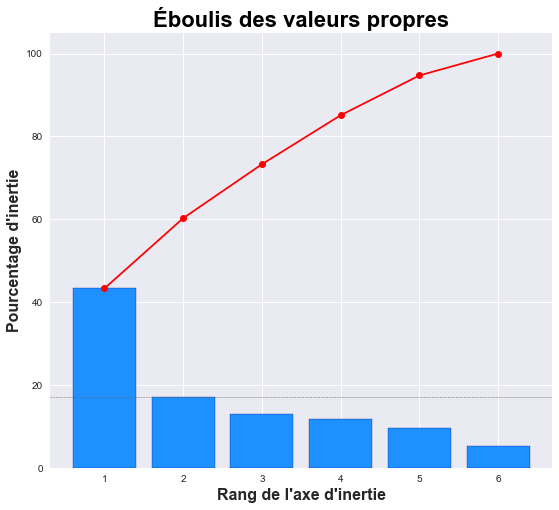

In [55]:
display_scree_plot(pca)

In [56]:
# projeter X sur les composantes principales
X_projected = pca.transform(X_scaled)

# Transformation en DataFrame pandas
data_pca_df = pd.DataFrame({
    "Dim1" : X_projected[:,0], 
    "Dim2" : X_projected[:,1],
    "Genuine" : index
})

# Résultat (premières lignes)
data_pca_df.head()

,Dim1,Dim2,Genuine
0,1.644104,0.747792,0
1,-2.019920,-2.207480,1
2,-0.969838,2.620523,2
3,-1.377480,-1.818400,3
4,0.148718,-0.566777,4


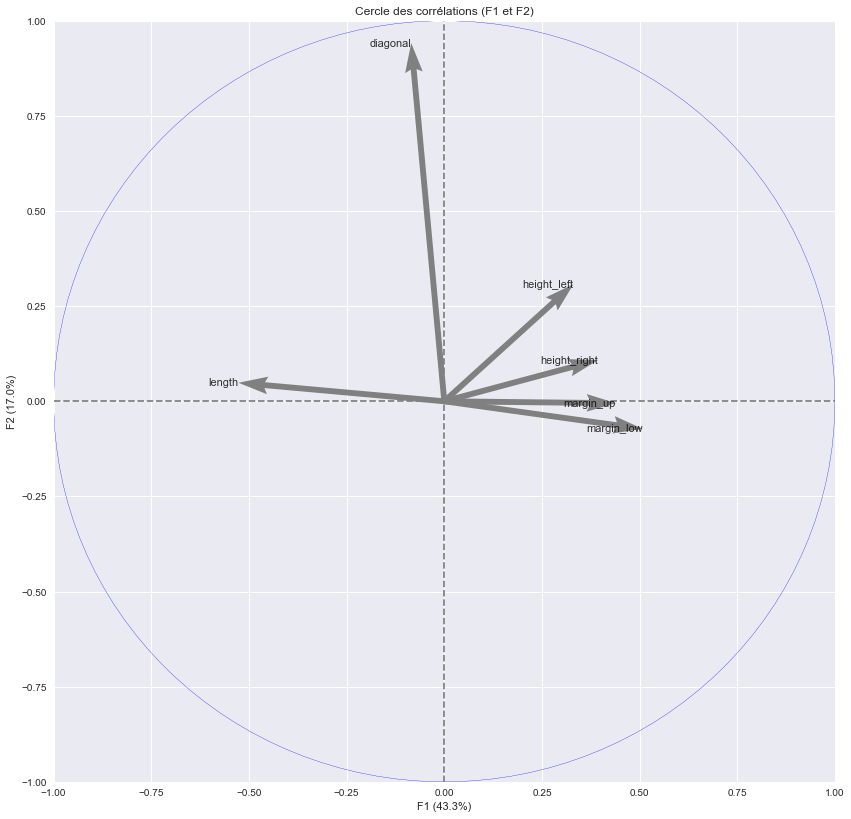

In [57]:
# Cercle des corrélations
pcs = pca.components_
display_circles(pcs, n_comp, pca, [(0,1)], labels = np.array(features))

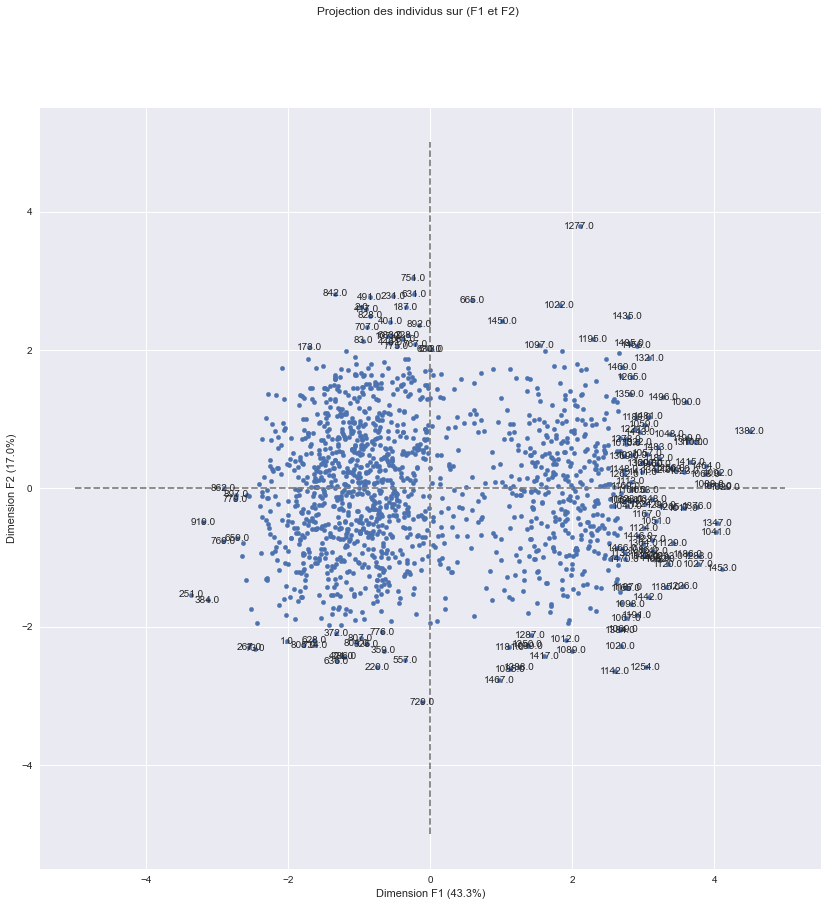

In [58]:
# utilisation de subplots nécessaire car annotation du graphique
fig, ax = plt.subplots(figsize=(14,14))
data_pca_df.plot.scatter("Dim1", "Dim2", ax = ax) # l'option ax permet de placer les points et le texte sur le même graphique

# boucle sur chaque pays
for k in data_pca_df.iterrows():
    # annotation uniquement si valeur absolue sur une de 2 dimensions importantes (valeurs choisies empiriquement)
    if (abs(k[1]['Dim1']) > 2.7) | (abs(k[1]['Dim2']) > 2):
        ax.annotate(k[1]["Genuine"], (k[1]['Dim1'], k[1]['Dim2']), fontsize = 10, ha='center',va='center')

# affichage des lignes horizontales et verticales
plt.plot([-5, 5], [0, 0], color='grey', ls='--')
plt.plot([0, 0], [-5, 5], color='grey', ls='--')
        
plt.xlabel("Dimension F1 (43.3%)") 
plt.ylabel("Dimension F2 (17.0%)")
plt.suptitle("Projection des individus sur (F1 et F2)")
plt.show()

In [59]:
data_pca_k = data_pca_df.assign(classe = kmeans2.labels_)
data_centroid = data_pca_k.drop(columns = ["Genuine", "classe"])

#kmeans2 = KMeans(n_clusters = 2)
#kmeans2.fit(data_centroid)
kmeansacp = KMeans(n_clusters = 2)
kmeansacp.fit(data_centroid)

KMeans(n_clusters=2)

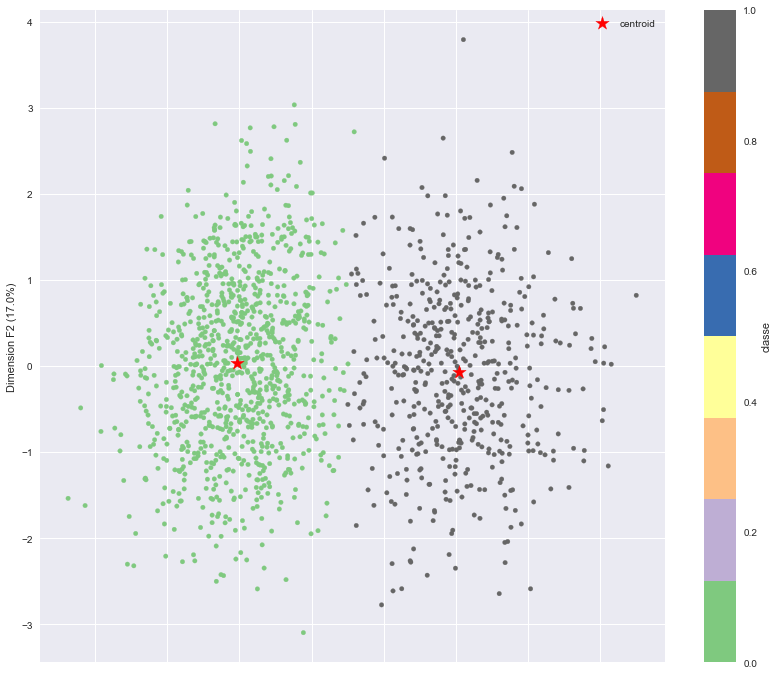

In [60]:
data_pca_k4 = data_pca_df.assign(classe = kmeansacp.labels_)
data_pca_k4.plot.scatter(x = "Dim1", y = "Dim2", c = "classe", cmap = "Accent", figsize=(14,12))
plt.scatter(kmeansacp.cluster_centers_[:,0],kmeansacp.cluster_centers_[:,1], color='red', marker='*', s=200, label='centroid')
plt.legend()
plt.xlabel("Dimension F1 (43.3%)") 
plt.ylabel("Dimension F2 (17.0%)")
plt.show()

In [61]:
#Verification de la classification: Matrice de confusion:
clusters_km2 = kmeansacp.labels_
km_matrix = pd.crosstab(clusters_km2, billet_final_df["is_genuine"])
print(km_matrix)

is_genuine  False  True
row_0                  
0              12   985
1             488    15


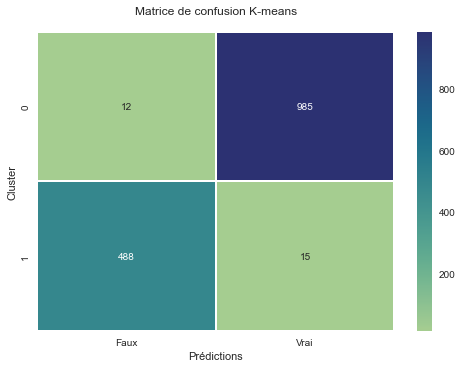

In [62]:
# Graphique:
sns.heatmap(km_matrix, annot = True, fmt = ".3g", cmap = sns.color_palette("crest", as_cmap=True), linecolor = "white", linewidths = 0.3,
            xticklabels = ["Faux","Vrai"],
            yticklabels=["0","1"]
            )
plt.xlabel("Prédictions")
plt.ylabel("Cluster")
plt.title("Matrice de confusion K-means\n")
plt.show()

Comme attendu, notre classification n'est pas parfaite, le premier groupe "Cluster 1" semble correspondre à des faux billets tandis que l'autre groupe "Cluster 0" semble correspondre à de vrais billets.

## <font color="#2E8B57">Prédictions K-MEANS</font>

In [63]:
# Predictions sur des donnees inconnues:
x_test_km = billets_production_df[["diagonal","height_left","height_right","margin_low","margin_up","length"]]

billets_production_df["cluster_pred"] = kmeans2.predict(x_test_km)
print(billets_production_df[["id","cluster_pred"]])

    id  cluster_pred
0  A_1             1
1  A_2             1
2  A_3             1
3  A_4             0
4  A_5             0


Nous obtenons comme résultats que les 3 premiers billets appartiennent au cluster 0, qui sont le groupe des faux billets, tandis que les 2 derniers appartiennent au cluster 1, des vrais billets.

# <font color="#8333ff">RÉGRESSION LOGISTIQUE</font>

## Visualisation et ordre des données

In [64]:
# y (authenticite): 
y_billet = billet_final_df.loc[:, billet_final_df.columns == "is_genuine"]
print(y_billet.value_counts())
print("\n")
# X (les autres):
X_billet = billet_final_df.loc[:, billet_final_df.columns != "is_genuine"]
X_billet = sm.tools.add_constant(X_billet)
print(X_billet.head())

is_genuine
True          1000
False          500
dtype: int64


   const  diagonal  height_left  height_right  margin_low  margin_up  length
0    1.0    171.81       104.86        104.95        4.52       2.89  112.83
1    1.0    171.46       103.36        103.66        3.77       2.99  113.09
2    1.0    172.69       104.48        103.50        4.40       2.94  113.16
3    1.0    171.36       103.91        103.94        3.62       3.01  113.51
4    1.0    171.73       104.28        103.46        4.04       3.48  112.54


## Regression logistique

In [65]:
# Regression logistique:
reg_log = Logit(endog=y_billet, exog=X_billet)
# Calculs:
res_log = reg_log.fit()
# Resume des resultats:
print(res_log.summary())

Optimization terminated successfully.
         Current function value: 0.028226
         Iterations 13
                           Logit Regression Results                           
Dep. Variable:             is_genuine   No. Observations:                 1500
Model:                          Logit   Df Residuals:                     1493
Method:                           MLE   Df Model:                            6
Date:                Fri, 05 Aug 2022   Pseudo R-squ.:                  0.9557
Time:                        14:05:54   Log-Likelihood:                -42.339
converged:                       True   LL-Null:                       -954.77
Covariance Type:            nonrobust   LLR p-value:                     0.000
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         -204.5600    241.768     -0.846      0.397    -678.417     269.297
diagonal         0.068

Il y a des variables x non-significatives au seuil alpha 5 % (si on prend alpha 1 %, on enlèvera height_right en plus), on recommence la régression sans ces variables (diagonal, height_left).

## Régression logistique des variables significatives

In [66]:
# On ne garde que les variables significatives a alpha = 5% dans X_Billet:
X_billet = billet_final_df[["height_right","margin_low", "margin_up", "length"]]
X_billet = sm.add_constant(X_billet)

# On recommence la regression logistique:
reg_log = Logit(endog=y_billet, exog=X_billet)

# Creation du modele:
model_reg_log = reg_log.fit()

# Resume des resultats:
print(model_reg_log.summary2())

Optimization terminated successfully.
         Current function value: 0.029055
         Iterations 12
                         Results: Logit
Model:                Logit            Pseudo R-squared: 0.954   
Dependent Variable:   is_genuine       AIC:              97.1658 
Date:                 2022-08-05 14:05 BIC:              123.7319
No. Observations:     1500             Log-Likelihood:   -43.583 
Df Model:             4                LL-Null:          -954.77 
Df Residuals:         1495             LLR p-value:      0.0000  
Converged:            1.0000           Scale:            1.0000  
No. Iterations:       12.0000                                    
-----------------------------------------------------------------
               Coef.   Std.Err.    z    P>|z|    [0.025   0.975] 
-----------------------------------------------------------------
const        -323.4359 139.5428 -2.3178 0.0205 -596.9348 -49.9369
height_right   -2.7846   1.0779 -2.5834 0.0098   -4.8973  -0.6720

- P-value est inférieure à 0.05, le modèle est significatif dans son ensemble.
- Le pseudo R² est très proche de 1, notre modèle explique donc la majorité de la variance observée.

## <font color="#800080">Test d'hypothèses</font>

# <font color="#1E90ff">Test de Wald</font>
Il s’agit d’un test d’hypothèse effectué sur les paramètres calculés par l’Estimation du Maximum de Vraisemblance (MLE). En termes simples, plus cette valeur d’estimation de wald est grande, moins il est probable que les paramètres d'entrée soient vrais.

In [67]:
# Test de Wald:
print("Avant élimination des variables non-significatives:\n", res_log.wald_test_terms(scalar=False))
print("\n")
print("Après élimination des variables non-significatives:\n", model_reg_log.wald_test_terms(scalar=False))

Avant élimination des variables non-significatives:
                                   chi2                  P>chi2  df constraint
const           [[0.7158854508944296]]      0.3974968813414328              1
diagonal      [[0.003894677857433199]]      0.9502384385782389              1
height_left     [[2.4177781393411255]]     0.11996497542872424              1
height_right     [[4.441007420645552]]    0.035085538367976586              1
margin_low      [[37.984337513269864]]   7.131483502475745e-10              1
margin_up       [[23.199730176901785]]  1.4601781487361431e-06              1
length           [[48.86695923260651]]    2.73926594171259e-12              1


Après élimination des variables non-significatives:
                                chi2                  P>chi2  df constraint
const         [[5.372311551633258]]    0.020458847659472788              1
height_right  [[6.673899527753587]]    0.009783489924605046              1
margin_low     [[45.0429809324109]]  1.9275

In [68]:
waldtest = model_reg_log.wald_test(r_matrix = 'const = 1', use_f = True, scalar=False)
waldtest

<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=array([[5.40558317]]), p=0.020205751198866684, df_denom=1.5e+03, df_num=1>

On confirme ici que nous n'avons gardé que les variables significatives.

# <font color="#1E90ff">Test binarite</font>
La régression logistique binaire nécessite que la variable dépendante soit binaire. Ici is_genuine ne peut prendre que deux valeurs, l'hypothèse est vérifiée.

In [69]:
print(billet_final_df["is_genuine"].nunique())

2


Il n'y a bien que deux valeurs possibles pour la variable prédite.

# <font color="#1E90ff">Multicollinearite</font>

In [70]:
vif= pd.Series([variance_inflation_factor(X_billet.values, i)
               for i in range(X_billet.shape[1])],
              index=X_billet.columns)
print("VIF par features:\n", vif)
print("VIF moyen:",vif.mean())

VIF par features:
 const           185218.409599
height_right         1.246890
margin_low           1.906461
margin_up            1.411965
length               2.113915
dtype: float64
VIF moyen: 37045.01776599213


- Une valeur de 1 indique qu'il n'y a pas de corrélation entre une variable explicative donnée et toute autre variable explicative du modèle.

- Une valeur entre 1 et 5 indique une corrélation modérée entre une variable explicative donnée et d'autres variables explicatives dans le modèle, mais cela n'est souvent pas assez grave pour nécessiter une attention particulière.

- Une valeur supérieure à 5 indique une corrélation potentiellement sévère entre une variable explicative donnée et d'autres variables explicatives du modèle. Dans ce cas, les estimations des coefficients et les valeurs de p dans la sortie de la régression ne sont probablement pas fiables.

Aucune des variables n'a de VIF supérieur à 5.
Il n'y a donc pas de collinéarité

Application du modèle:
---

In [71]:
# Application du modelé sur les données training:
billet_final_df["proba"] = model_reg_log.predict(X_billet)
billet_final_df["y_pred"] = (model_reg_log.predict(X_billet) >= 0.5).astype(int)
billet_final_df.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,proba,y_pred
0,True,171.81,104.86,104.95,4.52,2.89,112.83,0.939778,1
1,True,171.46,103.36,103.66,3.77,2.99,113.09,0.999989,1
2,True,172.69,104.48,103.50,4.40,2.94,113.16,0.999873,1
3,True,171.36,103.91,103.94,3.62,3.01,113.51,0.999999,1
4,True,171.73,104.28,103.46,4.04,3.48,112.54,0.883821,1


Evaluation du modèle:
---

[[32.8         0.53333333]
 [ 0.2        66.46666667]]


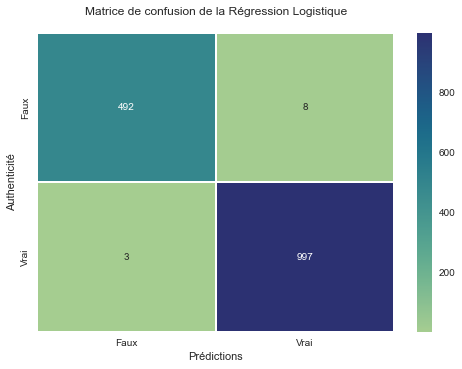

In [72]:
# Matrice de confusion:
n_reg_lin = 1500
conf_matrix_reg_log = model_reg_log.pred_table()
prct = (conf_matrix_reg_log*100)/n_reg_lin
print(prct)

# Graphique:
sns.heatmap(conf_matrix_reg_log, annot = True, fmt = ".3g", cmap = sns.color_palette("crest", as_cmap=True),
            linecolor = "white", linewidths = 0.3, xticklabels = ["Faux","Vrai"], yticklabels=["Faux","Vrai"]
            )
plt.xlabel("Prédictions")
plt.ylabel("Authenticité")
plt.title("Matrice de confusion de la Régression Logistique\n")
plt.show()

## Score de classification de précision

In [73]:
#Score de classification de précision.
#Dans la classification multiétiquette, cette fonction calcule la précision du sous-ensemble :
#l'ensemble d'étiquettes prédit pour un échantillon doit correspondre exactement à l'ensemble d'étiquettes correspondant dans y_true.
print("Accuracy Score: ", accuracy_score(billet_final_df["is_genuine"], billet_final_df["y_pred"]))

#La précision est le rapport tp / (tp + fp) où tp est le nombre de vrais positifs et fp le nombre de faux positifs.
#Le ratio de vrais positifs sur le total des prédictions positives.
print("Precision Score: ", precision_score(billet_final_df["is_genuine"], billet_final_df["y_pred"]))

#Le rappel est le rapport tp / (tp + fn) où tp est le nombre de vrais positifs et fn le nombre de faux négatifs.
#Le ratio de positif prédit correctement parmi tous les positifs. 
print("Recall Score: ", recall_score(billet_final_df["is_genuine"], billet_final_df["y_pred"]))

#Le score F1 peut être interprété comme une moyenne harmonique de la précision et du rappel, 
#où un score F1 atteint sa meilleure valeur à 1 et son pire score à 0.
print("Score F1: ", f1_score(billet_final_df["is_genuine"], billet_final_df["y_pred"]))

Accuracy Score:  0.9926666666666667
Precision Score:  0.9920398009950249
Recall Score:  0.997
Score F1:  0.9945137157107232


In [74]:
print(classification_report(billet_final_df["is_genuine"], billet_final_df["y_pred"]))

              precision    recall  f1-score   support

       False       0.99      0.98      0.99       500
        True       0.99      1.00      0.99      1000

    accuracy                           0.99      1500
   macro avg       0.99      0.99      0.99      1500
weighted avg       0.99      0.99      0.99      1500



Notre modèle est quasiment parfait puisque tous les scores s'approchent de 1. Ce n'est pas très réaliste, mais cela prouve qu'il fonctionne.

## <font color="#2E8B57">Courbe R.O.C.</font>
La courbe ROC est une mesure de la performance d’un classificateur binaire.
On représente la mesure ROC sous la forme d'une courbe qui donne le taux de vrais positifs en fonction du taux de faux positifs.

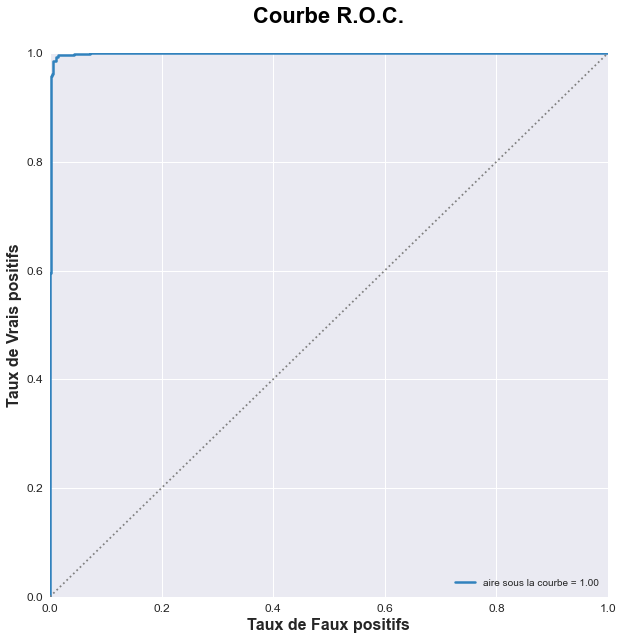

In [75]:
# Courbe R.O.C.:
fpr, tpr, _ = roc_curve(billet_final_df["is_genuine"], billet_final_df["proba"])
roc_auc = roc_auc_score(billet_final_df["is_genuine"], billet_final_df["proba"])

# Graphique:
plt.style.use('seaborn')
fig, ax = plt.subplots(figsize = (10,10))
ax.set_title("Courbe R.O.C.",
 fontsize=22, weight='bold', color='Black', loc='center',pad=30)
plt.box(True)

plt.plot(fpr, tpr, color="#3182bd", linewidth=2.5, label="aire sous la courbe = %0.2f" % roc_auc)
plt.plot([0, 1], [0, 1],color="grey", linestyle=":")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend(loc = "lower right")
plt.ylabel("Taux de Vrais positifs", weight='bold', size=16)
plt.xlabel("Taux de Faux positifs", weight='bold', size=16)
plt.xticks(rotation=0, fontsize=12)
plt.yticks(rotation=0, fontsize=12)

plt.show()

In [76]:
print("AUC :",roc_auc)

AUC : 0.998824


- AUC = 1  (Classificateur parfait, dans le meilleur des cas)
- AUC = 0.5  (Classificateur inutile, dans le pire des cas)
- Notre AUC = 0.9988

Comme avec les metrics calculées plus haut, on retombe sur un modèle quasiment parfait avec une aire sous la courbe approximée à 1.

# <font color="#8333ff">APPLICATION DU MODÈLE AUX DONNÉES TEST</font>

In [77]:
# Prediction sur des donnes inconnues:
X_test = billets_production_df[["height_right","margin_low","margin_up","length"]]
X_test = sm.add_constant(X_test)
billets_production_df["proba"] = model_reg_log.predict(X_test)
billets_production_df["y_pred"] = (model_reg_log.predict(X_test) >= 0.5).astype(int)
print(billets_production_df[["id","proba","y_pred"]])

# Affichage des resultats:
print("\nIdentification des billets:")
for i, k in zip(billets_production_df["y_pred"], billets_production_df["id"]):
    if i == 1:
        print("Le billet","{}".format(k),"est vrai")
    else:
        print("Le billet","{}".format(k),"est faux")

    id     proba  y_pred
0  A_1  0.000041       0
1  A_2  0.000003       0
2  A_3  0.000019       0
3  A_4  0.996708       1
4  A_5  0.999988       1

Identification des billets:
Le billet A_1 est faux
Le billet A_2 est faux
Le billet A_3 est faux
Le billet A_4 est vrai
Le billet A_5 est vrai


In [78]:
billets_production_df

,diagonal,height_left,height_right,margin_low,margin_up,length,id,cluster_pred,proba,y_pred
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1,1,0.000041,0
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2,1,0.000003,0
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3,1,0.000019,0
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4,0,0.996708,1
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5,0,0.999988,1


In [79]:
def evaluation(nom_fichier):
    print("On va estimer les billets du fichier: "+ nom_fichier)
    billets_test_df = pd.read_csv(nom_fichier, sep=",", decimal='.')
    # Prediction sur des donnes inconnues:
    X_test = billets_test_df[["height_right","margin_low","margin_up","length"]]
    X_test = sm.add_constant(X_test)
    billets_test_df["proba"] = round(model_reg_log.predict(X_test),6)
    billets_test_df["y_pred"] = (model_reg_log.predict(X_test) >= 0.5).astype(int)
    print(billets_test_df[["id","proba","y_pred"]])

    # Affichage des resultats:
    print("\nIdentification des billets:")
    for i, k in zip(billets_test_df["y_pred"], billets_test_df["id"]):
        if i == 1:
            print("Le billet","{}".format(k),"est vrai")
        else:
            print("Le billet","{}".format(k),"est faux")

In [80]:
evaluation('billets_production.csv')

On va estimer les billets du fichier: billets_production.csv
    id     proba  y_pred
0  A_1  0.000041       0
1  A_2  0.000003       0
2  A_3  0.000019       0
3  A_4  0.996708       1
4  A_5  0.999988       1

Identification des billets:
Le billet A_1 est faux
Le billet A_2 est faux
Le billet A_3 est faux
Le billet A_4 est vrai
Le billet A_5 est vrai
